In [9]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameters ----
Generations:    100
Iterations:     100
Total iters:    10000
Signal power:   0.00 dB
Sig cent. freq: -150000.0 Hz
Noise power:    10.00 dB
Noise uncert:   3.00 dB
SNR:            -10.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band to detect: 1
Band noise est: 3
Est. hist.:     10
Covari. size:   20
---- Simulation stats theory ----
Prob false alarm: 0.1000
Prob detection:   0.9997
Threshold:        1.0840
---- Running simulation ----
Using 8 processes on 8 cores


100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


---- Simulation stats ----
Prob false alarm theory:      0.1000
Prob false alarm sim:         0.0856
Prob detection theory (post): 0.9674
Prob detection sim:           0.9586


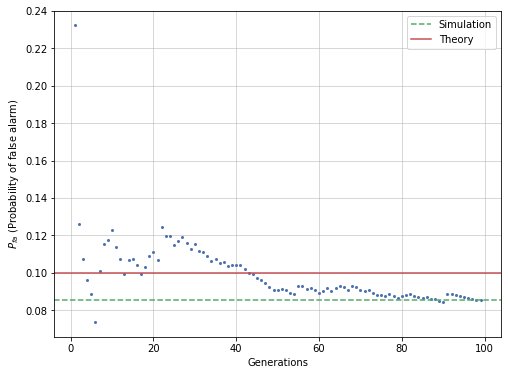

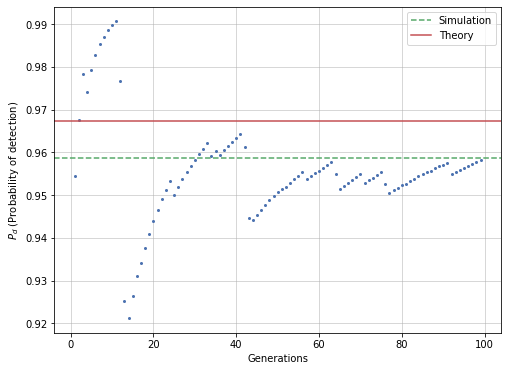

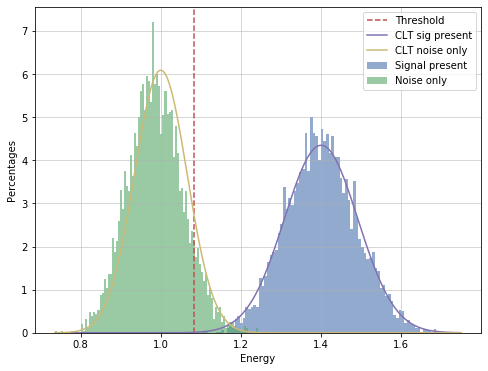

---- Distribution stats ----
Sig present mean: 1.4013
Sig absent  mean: 0.9869
Sig present var:  0.0078
Sig absent  var:  0.0048
Sig present std:  0.0885
Sig absent  std:  0.0691


In [10]:
# wideband band energy detector simulation

_ = ss.eigenvalue_estimation_sim(
    gens=100,  # generations, number of environments
    itrs=100,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=0.0,  # in dB
    noise_power=10,  # in dB
    length_sec=0.001024,  # length of each sample in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_uncert=3.0,  # standard deviation of the noise normal distribution in dB
    num_procs=None,  # number of processes to run in parallel
    seed=None,  # set seed for reproducibility
    window='box',  # window used with fft
    fft_len=1024,  # samples used for fft
    num_bands=4,  # total number of bands
    f_center=-1.5e5,  # signal center frequency
    band_to_detect=1,  # band to 'search' for signal in
    band_noise_est=3,  # band to use for noise estimation
    noise_est_hist=10,  # depth of noise estimation buffer
    cov_size=20)

# windows, except for the 'box' (rectangular) window distort the energy distribution
# and result in wrong statistics -> try 'flattop' for example